In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
df = pd.read_json("./bquxjob_36320739_189d566c567.json")

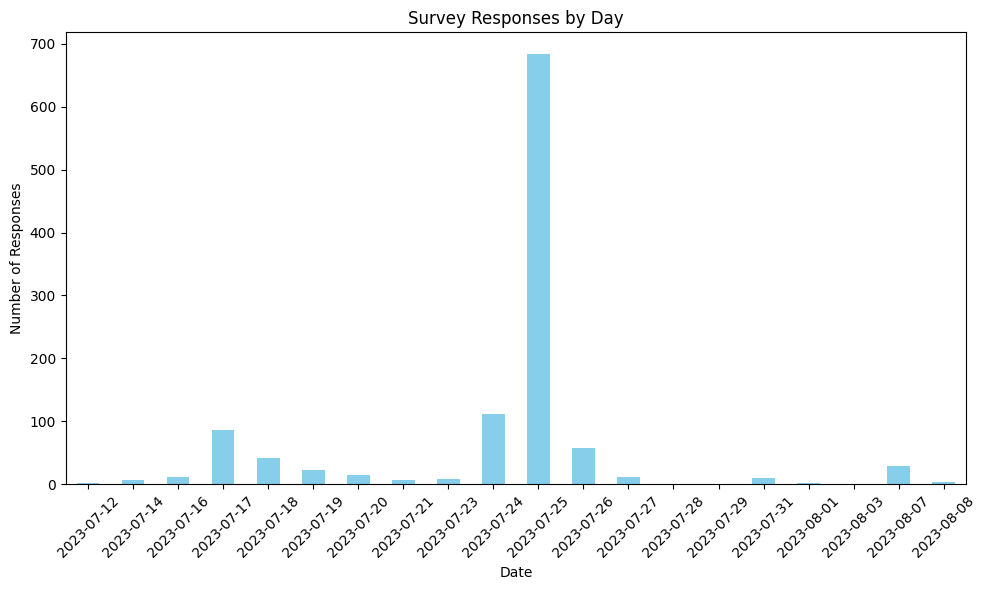

In [4]:
# Convert submitted_at column to datetime format
df['submitted_at'] = pd.to_datetime(df['submitted_at'])

# Extract the date part of the datetime
df['submission_date'] = df['submitted_at'].dt.date

# Count the number of submissions per date
date_counts = df['submission_date'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
date_counts.plot(kind='bar', color='skyblue')
plt.title('Survey Responses by Day')
plt.xlabel('Date')
plt.ylabel('Number of Responses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Helper function to transform answers into a binary array
def answers_to_array(answers):
    # Extract all the question keys from the answers column
    question_keys = [ans['key'] for ans in answers]
    # Create the binary array where 1 indicates a question was answered and 0 indicates it was not
    binary_array = [1 if key in question_keys else 0 for key in all_questions]
    return binary_array

# Extract all unique questions across all submissions
all_questions = set()
for answers in df['answers']:
    for ans in answers:
        all_questions.add(ans['key'])
all_questions = sorted(list(all_questions))

# Transform the answers column into the binary format
df['binary_answers'] = df['answers'].apply(answers_to_array)

# Extract the list of binary arrays
binary_arrays = df['binary_answers'].tolist()

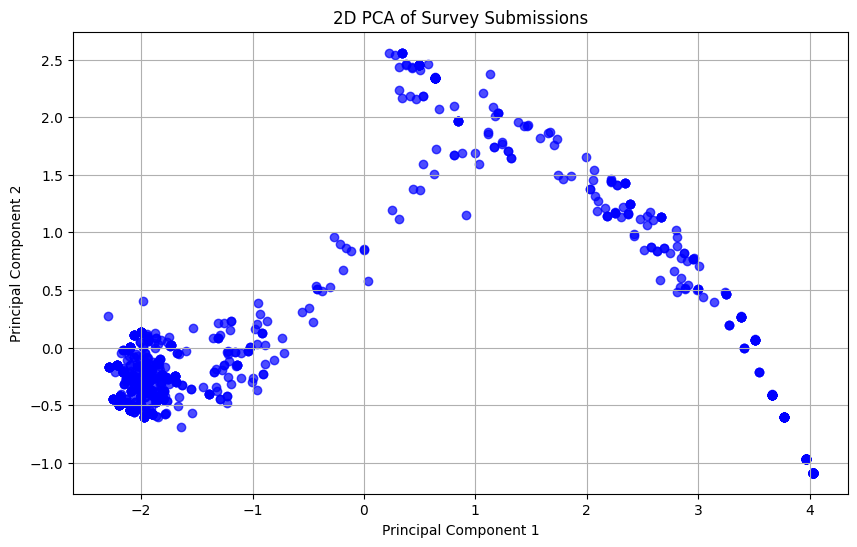

In [6]:
# Apply PCA and reduce dimensionality to 2 components
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(binary_arrays)

# Plotting the reduced data on a 2D axis
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.7, color='blue')
plt.title('2D PCA of Survey Submissions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

/Users/jb/dev/awell-python/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


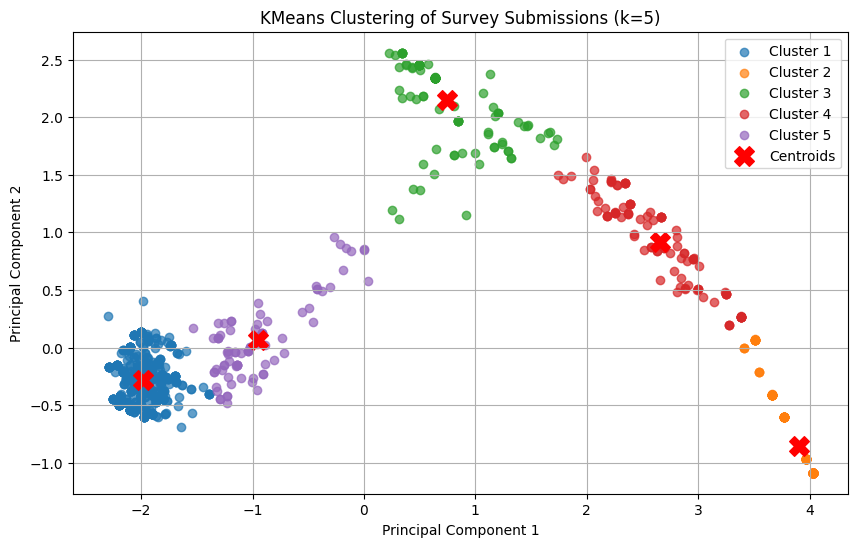

In [8]:
from sklearn.cluster import KMeans

num_clusters = 5
# Apply KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# Plotting the reduced data on a 2D axis with cluster colors
plt.figure(figsize=(10, 6))
for cluster_num in range(num_clusters):
    plt.scatter(reduced_data[clusters == cluster_num, 0], 
                reduced_data[clusters == cluster_num, 1], 
                alpha=0.7, 
                label=f'Cluster {cluster_num+1}')

# Plotting the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')

plt.title(f'KMeans Clustering of Survey Submissions (k={num_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Applying KMeans clustering with 5 clusters
kmeans_5 = KMeans(n_clusters=5, random_state=42)
clusters_5 = kmeans_5.fit_predict(reduced_data)

# Counting the number of submissions in each of the 5 clusters
cluster_counts_5 = pd.Series(clusters_5).value_counts().sort_index()

clust = pd.Series(clusters_5)


/Users/jb/dev/awell-python/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
df['cluster'] = clusters_5

In [18]:
grouped_data = df.groupby(['submission_date', 'cluster']).size().unstack().fillna(0)

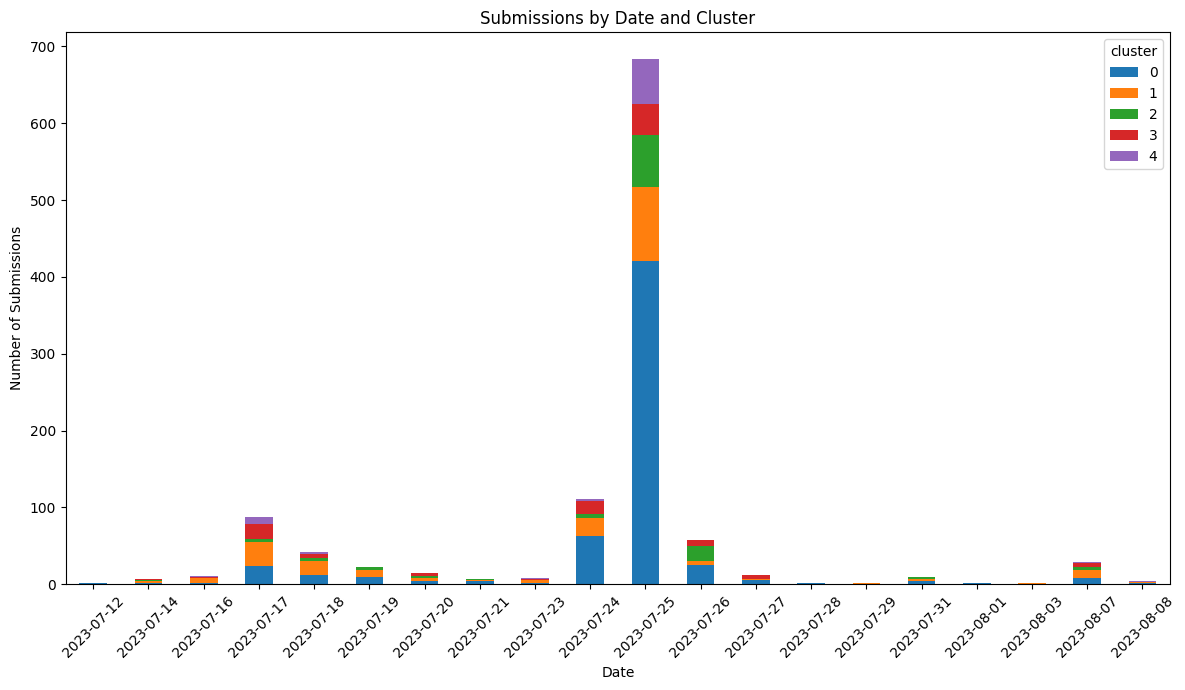

In [19]:
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(12, 7))
ax.set_title('Submissions by Date and Cluster')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Submissions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
df_sorted = df.sort_values(by='submitted_at')
counts = []
for index, row in df_sorted.iterrows():
    start_time = row['submitted_at'] - pd.Timedelta(minutes=1)
    end_time = row['submitted_at'] + pd.Timedelta(minutes=1)
    count = len(df_sorted[(df_sorted['submitted_at'] >= start_time) & (df_sorted['submitted_at'] <= end_time)])
    counts.append(count - 1)  # subtract 1 to exclude the current submission
df_sorted['nearby_submissions'] = counts

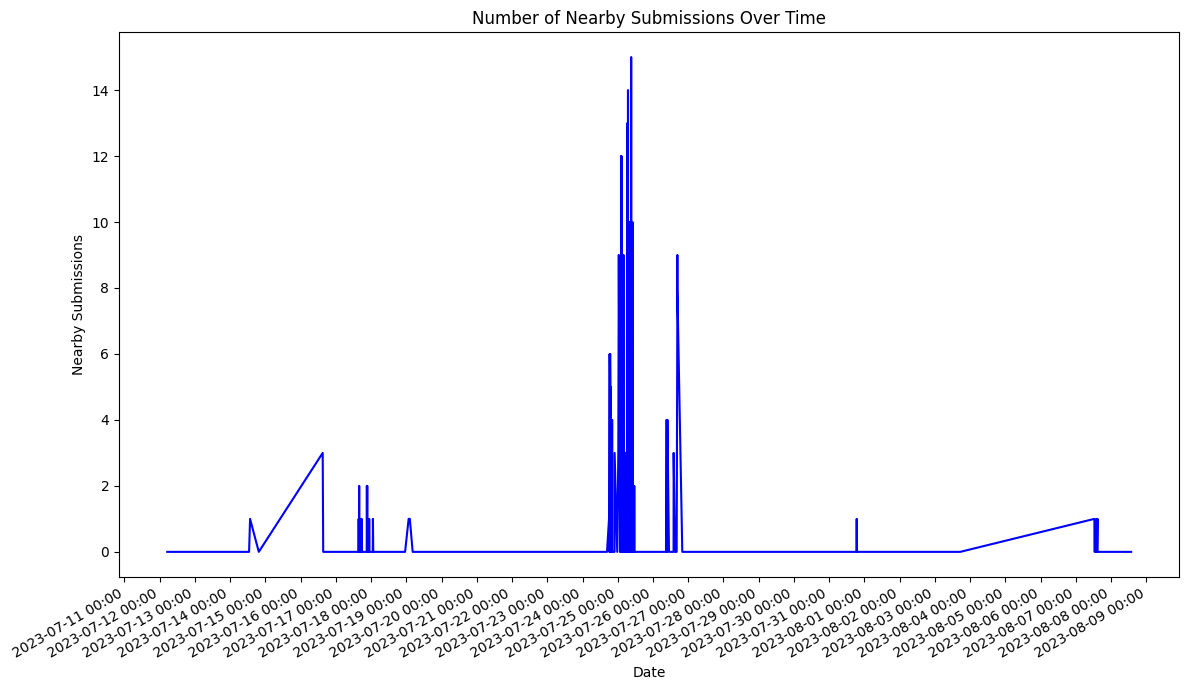

In [23]:
import matplotlib.dates as mdates

# Plotting the data
plt.figure(figsize=(12, 7))
plt.plot(df_sorted['submitted_at'], df_sorted['nearby_submissions'], color='blue', marker='o', linestyle='-')
plt.title('Number of Nearby Submissions Over Time')
plt.xlabel('Date')
plt.ylabel('Nearby Submissions')

# Setting the x-axis to have ticks every 24 hours
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.tight_layout()
plt.show()

In [28]:
july_24_26_responses = df[df['submitted_at'].dt.date.isin([pd.to_datetime('2023-07-24').date(), 
                                           pd.to_datetime('2023-07-25').date(), 
                                           pd.to_datetime('2023-07-26').date()])].sort_values(by='submitted_at')
july_24_26_responses

,submitted_at,responder_uuid,flow_label,variant_label,variant_revision_uuid,event_type,answers,schema_version,submission_date,binary_answers,cluster
33,2023-07-24 00:13:39+00:00,5145a0ef-cf5c-417a-b091-f3d0a454cef5,new-flow,fs_copy,12f12208-1b2b-4d59-a5a6-b7060db9f8aa,FlowFinalized,"[{'key': 'g2m_model', 'value': '[""dont_know""]'...",2,2023-07-24,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",2
56,2023-07-24 00:24:59+00:00,6cdb0d9f-33fa-41d2-93b9-bae2e3573651,new-flow,fs_copy,12f12208-1b2b-4d59-a5a6-b7060db9f8aa,FlowFinalized,"[{'key': 'number_of_care_flows', 'value': '""2""...",2,2023-07-24,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, ...",0
127,2023-07-24 01:03:13+00:00,2f68b1d9-ea5a-4277-8d1b-7d8db609400c,new-flow,fs_copy,12f12208-1b2b-4d59-a5a6-b7060db9f8aa,FlowFinalized,"[{'key': 'number_of_care_flows', 'value': '""un...",2,2023-07-24,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, ...",0
144,2023-07-24 01:06:46+00:00,7c1d8aab-2cf4-4c86-be31-73afacc77f18,new-flow,fs_copy,12f12208-1b2b-4d59-a5a6-b7060db9f8aa,FlowFinalized,"[{'key': 'takes_financial_risk', 'value': '""no...",2,2023-07-24,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",2
32,2023-07-24 01:28:10+00:00,da911a94-03b4-4cca-8bf0-b20da3e379a8,new-flow,fs_copy,12f12208-1b2b-4d59-a5a6-b7060db9f8aa,FlowFinalized,"[{'key': 'g2m_model', 'value': '[""dont_know""]'...",2,2023-07-24,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",2
...,...,...,...,...,...,...,...,...,...,...,...
339,2023-07-26 16:34:14+00:00,c5c658da-8191-4168-a28a-e35f9fc71549,new-flow,fs_copy,12f12208-1b2b-4d59-a5a6-b7060db9f8aa,FlowFinalized,"[{'key': 'number_of_care_flows', 'value': '""23...",2,2023-07-26,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, ...",0
869,2023-07-26 16:34:16+00:00,e4b58c6f-3958-4ed0-9c85-b47c54433ee9,new-flow,fs_copy,12f12208-1b2b-4d59-a5a6-b7060db9f8aa,StepCompleted,"[{'key': 'number_of_care_flows', 'value': '""40...",2,2023-07-26,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, ...",0
375,2023-07-26 16:34:21+00:00,325be9ea-836a-4c13-8fdf-14174b4bf841,new-flow,fs_copy,12f12208-1b2b-4d59-a5a6-b7060db9f8aa,FlowFinalized,"[{'key': 'number_of_care_flows', 'value': '""30...",2,2023-07-26,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, ...",0
367,2023-07-26 16:34:25+00:00,8d500207-52fe-4722-85ae-67abf2c176e4,new-flow,fs_copy,12f12208-1b2b-4d59-a5a6-b7060db9f8aa,FlowFinalized,"[{'key': 'number_of_care_flows', 'value': '""30...",2,2023-07-26,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, ...",0
